# Setup

In [ ]:
%%bash
wget -q -O emp500.tar.gz "https://www.dropbox.com/scl/fi/7sepykr3vhss60647osc8/emp500.tar.gz?rlkey=6q5ac48noeax5n2htaqslvo8g&dl=0"
tar -zxvf emp500.tar.gz

In [1]:
import biom
import pandas as pd
import numpy as np
from functools import partial

from skbio.diversity.beta import unweighted_unifrac
from skbio.diversity import beta_diversity
from skbio.diversity._util import _vectorize_counts_and_tree as vectorize_counts_and_tree
from skbio import TreeNode
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

table = biom.load_table('emp500/amplicon/subset/16s.biom')
metadata = pd.read_table('emp500/sample.tsv', index_col=0)

# subset the table down for the sake of the tutorial
abundance_data = table.to_dataframe().T
md = metadata.loc[abundance_data.index]
tree = TreeNode.read('emp500/amplicon/subset/16s_labeled.nwk')
# remove dead nodes left over from subsetting
tree.prune()

In this tutorial, we will go over best practices when training classifiers, as well as how to use scikit-bios functions to build customized
classifiers that can leverage biological domain knowledge, such as phylogenetic trees.

# K-nearest neighbors classification with Unifrac

The underlying idea behind k-nearest neighbors (KNN) is using distances to classify new data points. For instance, if a patient to be diagnosed has biomarker profiles similar to 5 other disease patients, then the KNN classifier will classify the new patient as diseased.

The accuracy of KNN is highly dependent on the choice of distance metric. A commonly used metric is euclidean, which may not be ideal for omics data, particularly if there is the data is sparse (i.e. little overlap of biomarkers between samples).  This is where Unifrac shines. By incorporating phylogenetic relateness, Unifrac can take into account the evolutionary relateness of different biomarkers. This approach also extends to other omics data types that can incorporate other similar structures (i.e. molecular networks).

First, we will rerun beta diversity, passing in the abundance data, the phylogenetic tree, as well as the taxa names.  We will then show how we can use the resulting distance matrix to train an KNN classifier.

In [2]:
ids = abundance_data.index
taxa = abundance_data.columns
data = abundance_data.values
unifrac_dm = beta_diversity("weighted_unifrac", data, ids, tree=tree, taxa=taxa)

dist_mat = unifrac_dm.data
le = LabelEncoder()
labels = le.fit_transform(md['empo_1'])

Once we got the distance matrix, we can subet the distance matrix such that all of the distances between the training set samples are used for training the KNN. Furthermore, all of the distances involving the test set samples are excluded in training the KNN to be used for cross-validation.


In [3]:
# we will use the first entries in the table for training,
# and the rest for testing
n_train  = len(md) * 8 // 10 
# the upper left block is the pairwise distances between training samples
train_X = dist_mat[:n_train, :n_train]
train_y = labels[:n_train]
# entry X_ij in the lower left block contains distance
# between test sample i and training sample j.
test_X = dist_mat[n_train:, :n_train]
test_y = labels[n_train:]

Once the train / test splits are obtained, the KNN classifier can be trained.  Here, we will use the scikit-learn KNN configuration that allows for distance matrices to be directly passed in. We can then use this model to generate predictions for test set samples.

In [4]:
kneigh = KNeighborsClassifier(n_neighbors=2, metric='precomputed')
kneigh.fit(train_X, train_y)
test_pred = kneigh.predict(test_X)

Once the model is trained and evaluated, we can evaluate the accuracy. Below we will generate a confusion matrix.

[Text(0, 0.5, 'Free-living'), Text(0, 1.5, 'Host-associated')]

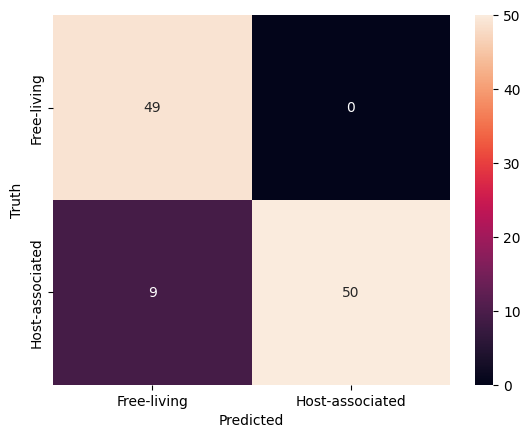

In [5]:
cm = confusion_matrix(test_y, test_pred)

# to be used later
unifrac_tpr, unifrac_fpr, thresholds = roc_curve(test_y, test_pred)

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Truth')
ax.set_xticklabels(le.classes_)
ax.set_yticklabels(le.classes_)

We can also compare this directly against other metrics such as Jaccard distance to evaluate the improvement in classification accuracy

In [6]:
kneigh = KNeighborsClassifier(n_neighbors=2, metric='jaccard')
train_data = data[:n_train]
test_data = data[n_train:]

kneigh.fit(train_data, train_y)
test_pred = kneigh.predict(test_data)

And we can use metrics from scikit-learn such as roc curves to evaluate the differences in classification accuracy.

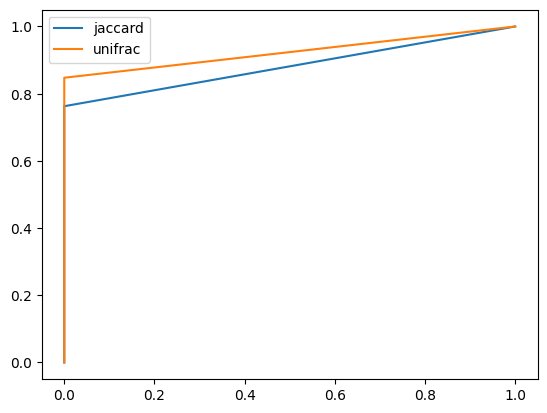

In [7]:
euc_tpr, euc_fpr, thresholds = roc_curve(test_y, test_pred)
plt.plot(euc_tpr, euc_fpr, label='jaccard')
plt.plot(unifrac_tpr, unifrac_fpr, label='unifrac')
plt.legend()

Overall, this showcases how Unifrac can be used for K-nearest neighbors classification, and can be a competitive tool compared to other distance metrics.

## Phylogenetic Random Forests

Underneadth the hood of the weighted Unifrac distance is a weighted L1-distance between both the taxa abundances and the internal node abundances, where

$$
d(x, y) = \sum_i l_i |x_i - y_i|
$$

Where $i$ represents a node in the phylogenetic tree, $x_i$ represents node abundances in sample $x$, $y_i$ represents node abundances in sample $y$ and $l_i$ represents the branch length for the corresponding node $i$. When considering a taxonomic tree, nodes could be species, genera, families, classes, orders or phyla.  When computing Unifrac distances, all of the node abundances are also considered.  Furthemore, we can directly compute these node abundances as follows

In [8]:
node_abundances, tree_index, branch_lengths = vectorize_counts_and_tree(abundance_data, taxa, tree)

Looking at dimensionality of the node_abundances, one can see that the number of features is dramatically larger than the original abundance dimensionality. This is because for each internal node, the internal node abundances represents the sum of all of the taxa underneadth it.

In [9]:
abundance_data.shape, node_abundances.shape

((539, 529), (539, 1038))

Instead of using these node abundances for computing Unifrac distances, we can also pass them directly into downstream ML models.
For instance, we can fit Random Forests using both the taxa abundances *and* the internal node abundances. This provides Random forests additional phylogenetic information to help further boost performance.

In [10]:
# we will use the first entries in the table for training,
# and the rest for testing
n_train  = len(md) * 8 // 10 
# the upper left block is the pairwise distances between training samples
train_X = node_abundances[:n_train]
train_y = labels[:n_train]
# entry X_ij in the lower left block contains distance
# between test sample i and training sample j.
test_X = node_abundances[n_train:]
test_y = labels[n_train:]

We can then pass these internal node abundances directly into Random Forests training and cross-validation

In [11]:
rf = RandomForestClassifier()
rf.fit(train_X, train_y)
test_pred = rf.predict(test_X)

Similarly, we can evaluate the classification accuracy below

Text(50.722222222222214, 0.5, 'Truth')

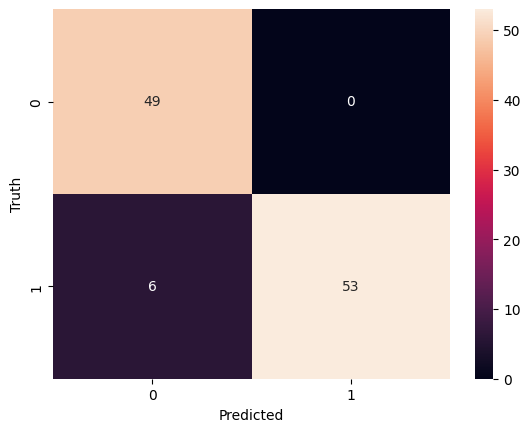

In [12]:
# to be used later
rf_phylo_tpr, rf_phylo_fpr, thresholds = roc_curve(test_y, test_pred)

cm = confusion_matrix(test_y, test_pred)
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

We can also compare this phylogenetically augmented random forests model to the standard random forests model

In [13]:
# we will use the first entries in the table for training,
# and the rest for testing
n_train  = len(md) * 8 // 10 
# the upper left block is the pairwise distances between training samples
train_X = abundance_data[:n_train]
train_y = labels[:n_train]
# entry X_ij in the lower left block contains distance
# between test sample i and training sample j.
test_X = abundance_data[n_train:]
test_y = labels[n_train:]

In [14]:
rf = RandomForestClassifier()
rf.fit(train_X, train_y)
test_pred = rf.predict(test_X)

Text(50.722222222222214, 0.5, 'Truth')

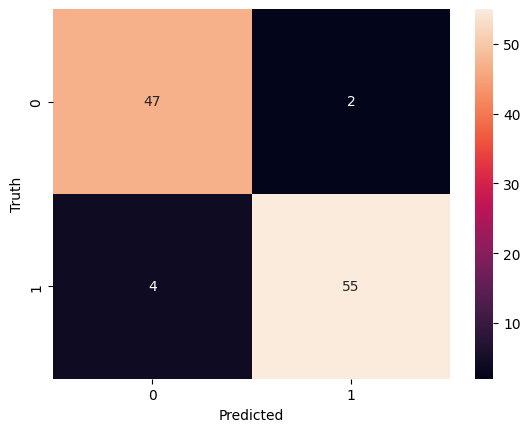

In [15]:
# to be used later
rf_tpr, rf_fpr, thresholds = roc_curve(test_y, test_pred)

cm = confusion_matrix(test_y, test_pred)
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

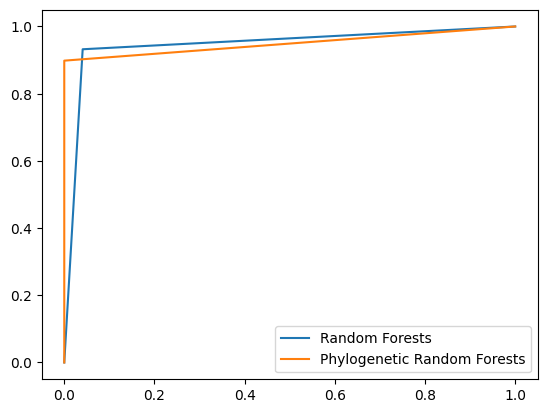

In [16]:
plt.plot(rf_tpr, rf_fpr, label='Random Forests')
plt.plot(rf_phylo_tpr, rf_phylo_fpr, label='Phylogenetic Random Forests')
plt.legend()

Altogether, this tutorial shows how one can incorporate biological domain knowledge such as phylogenetic trees into conventional machine learning tools.

Exercise : Can you convert the differential abundance analysis discussed previously into an sklearn compatible classifier?